In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timeit

import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras
AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters

matplotlib.style.use('ggplot')

In [139]:
import PIL
import PIL.Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import pathlib

# Create Dir path for each class

In [3]:
data_dir = pathlib.Path('images/')

In [431]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

7840


In [439]:
others = list(data_dir.glob('others/*'))
pedestrianCrossing = list(data_dir.glob('pedestrianCrossing/*'))
speedLimit = list(data_dir.glob('speedLimit/*'))
stop_sign = list(data_dir.glob('stop_sign/*'))
dct = {'others' :len(others),'pedestrianCrossing' :len(pedestrianCrossing),'speedLimit': len(speedLimit),'stop_sign': len(stop_sign)}
for k,v in dct.items():
    print(k,'  ',v,'samples -- ',round(100*v/7840,1),'%')

others    3396 samples --  43.3 %
pedestrianCrossing    947 samples --  12.1 %
speedLimit    1602 samples --  20.4 %
stop_sign    1896 samples --  24.2 %


In [15]:
PIL.Image.open(str(stop_sign[5]))

# Create Data for training 

#--Method 1 - using preprocessing

In [601]:
batch_size = 32
img_height = 100
img_width = 100


In [602]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  #labels ='inferred',
  subset="training",
  shuffle=True,
  seed=123,
  color_mode ='grayscale',
  label_mode = "int",
  image_size=(img_height, img_width),
  batch_size = batch_size)

Found 7840 files belonging to 4 classes.
Using 6272 files for training.


In [603]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  #labels ='inferred',
  subset="training",
  shuffle=True,
  seed=123,
  color_mode ='grayscale',
  label_mode = "int",
  image_size=(img_height, img_width),
  batch_size = batch_size)

Found 7840 files belonging to 4 classes.
Using 6272 files for training.


In [604]:

class_names = train_ds.class_names
np_class_names = np.array(class_names)
#sobel_ =tf.image.sobel_edges(train_ds)

X_train = []
y_train = []
for i,l in train_ds:
    X_train.append(i.numpy())
    y_train.append(l.numpy())
    #print(i.shape)
  

In [611]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train_scaled = X_train/255
print(X_train.shape)
print(X_train_scaled.shape)
print(y_train.shape)

(196, 32, 100, 100, 1)
(196, 32, 100, 100, 1)
(196, 32)


In [613]:
y_train[0,1]

2

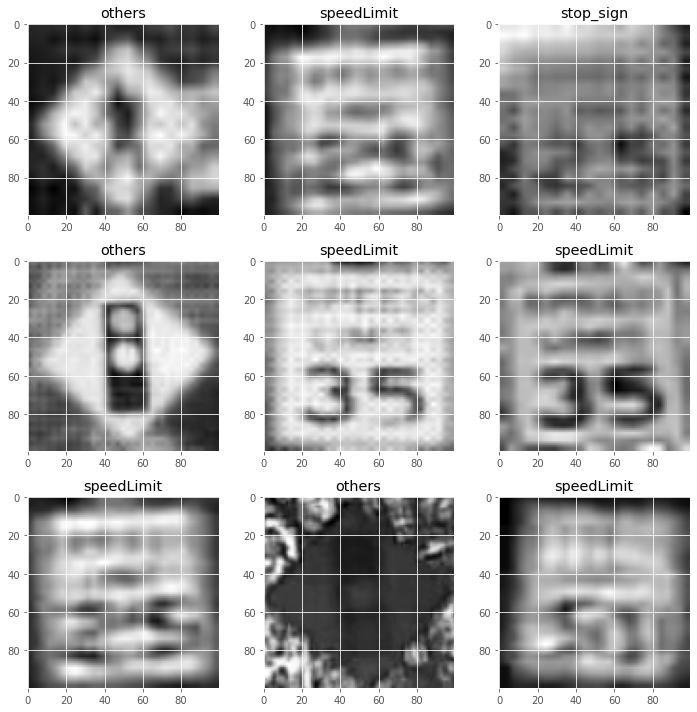

In [622]:
fig,axs = plt.subplots(3,3,figsize=(10,10))
for i,each in enumerate(X_train):
    for j,ax in enumerate(axs.flatten()):
        ax.imshow(each[j,...,0],cmap='gray')
        ax.set_title(class_names[y_train[i,j]])
    fig.tight_layout()
    break

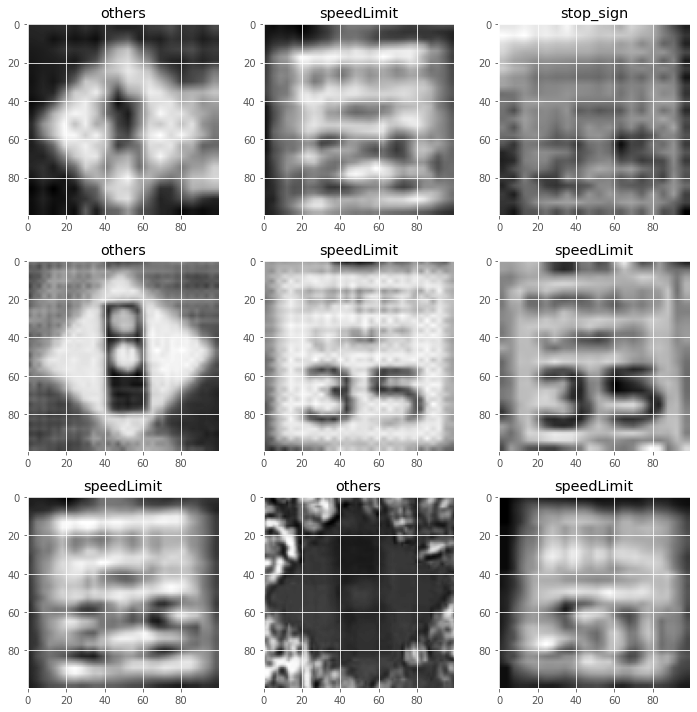

In [623]:
fig,axs = plt.subplots(3,3,figsize=(10,10))
for i,each in enumerate(X_train_scaled):
    for j,ax in enumerate(axs.flatten()):
        ax.imshow(each[j,...,0],cmap='gray')
        ax.set_title(class_names[y_train[i,j]])
    fig.tight_layout()
    break

In [ ]:
image

#-- Method 2: using imagedatagenerator

In [314]:
def augment(x,y):
    image = tf.image.random_brightness(x,max_delta=0.05)
    return image,y
#train_ds = train_ds.map(augment)

In [365]:
tf.keras.preprocessing.image.ImageDataGenerator?

Init signature:
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None,
)
Docstring:     
Generate batches of tensor image data with real-time data augmentation.

 The data will be looped over (in batches).

Arguments:
    featurewise_center: Boolean.
        Set input mean to 0 over the dataset, feature-wise.
    samplewise_center: Boolean. Set each sample mean to 0.
    featurewise_std_normalization: Boolean.
        Divide inputs by

In [386]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last',
    zoom_range=5)

In [387]:
images, labels = next(img_gen.flow_from_directory(data_dir))

Found 7840 images belonging to 4 classes.


In [388]:
print(images.shape

(32, 256, 256, 3)
(32, 4)


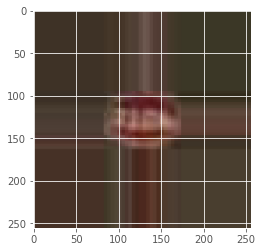

In [382]:
plt.imshow(images[1])

In [360]:
labels.shape

(32, 4)

In [361]:
ds = tf.data.Dataset.from_generator(
    lambda: img_gen.flow_from_directory(data_dir), 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([32,180,180,3], [32,4])
)

In [183]:
class_names = train_ds.class_names

class_name_dict = {'others': 0,'pedestrianCrossing':1,'speedLimit':2,'stop_sign':3}
class_names

['others', 'pedestrianCrossing', 'speedLimit', 'stop_sign']

# Visualize data

In [ ]:
tf.image.sobel_edges(train_ds)

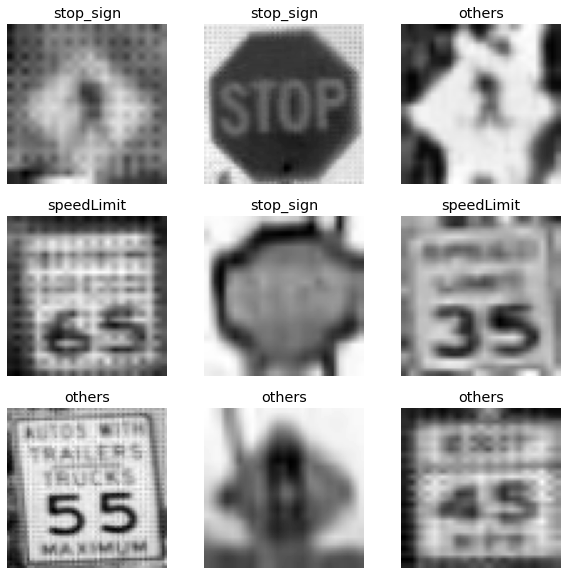

In [561]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i][...,0].numpy().astype('uint8'),cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [67]:
np_class_names = np.array(class_names)
for imgs,labels in train_ds.take(1):
    print(np_class_names[labels])
    

['others' 'others' 'others' 'others' 'others' 'others' 'others' 'others'
 'others' 'others' 'others' 'others' 'others' 'others'
 'pedestrianCrossing' 'stop_sign' 'others' 'others' 'stop_sign'
 'stop_sign' 'stop_sign' 'stop_sign' 'others' 'others' 'stop_sign'
 'stop_sign' 'others' 'others' 'stop_sign' 'others' 'others' 'others']


In [215]:
train_ds.take(2)

AttributeError: 'TakeDataset' object has no attribute 'shape'

In [ ]:
7840

In [214]:
5488/32

171.5

# Build train data pipeline

In [ ]:
tenserflow augmentation 